### Approximate distributions for counting stations

Look at the distributions of counts for different seasons, stations, etc.

In [269]:
from data_io.loader.data_loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [270]:
dl = DataLoader()

In [271]:
station = "Plöck"
interval_summer = ("2022-04-01", "2022-07-01")
interval_winter = ("2021-11-01", "2022-02-01")

In [272]:
def get_channel_values(station_name, channel="channels_all", interval=None):
    bike_station_data = dl.get_bicycle(station_name=station_name, interval=interval)
    bike_df = bike_station_data.df
    return bike_df[channel]

### Calculate CDF

In [273]:
def calc_empirical_cdf_with_dkw(station_name, channel = "channels_all", alpha = 0.05, interval = None):
  bike_df = get_channel_values(station_name=station_name, channel=channel, interval=interval)
  x = np.sort(bike_df)
  y = np.arange(1, len(x) + 1) / len(x)
  n = len(x)

  eps = np.sqrt(np.log(2 / alpha) / (2 * n))
  lower = np.clip(y - eps, 0, 1)
  upper = np.clip(y + eps, 0, 1)


  return x, y, lower, upper, eps

x, y, lower, upper, eps = calc_empirical_cdf_with_dkw(station, interval=interval_summer)

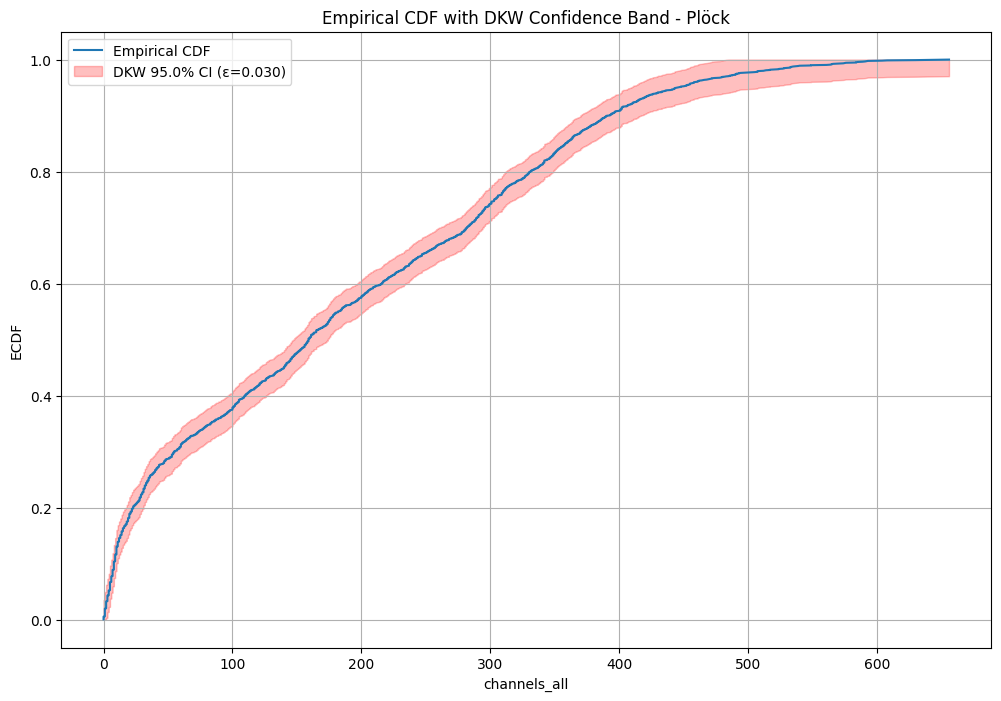

In [274]:
def plot_empirical_cdf_with_dkw(station_name, channel= "channels_all", alpha = 0.05, plot_alpha = 0.25, fig_size = (12,8), interval = None, color_ci = "red"):
  plt.figure(figsize=fig_size)
  plt.plot(x, y, label='Empirical CDF')
  plt.fill_between(x, lower, upper, color=color_ci, alpha=plot_alpha, label=f'DKW {100 - 100 * alpha}% CI (ε={eps:.3f})')
  plt.xlabel(channel)
  plt.ylabel('ECDF')
  plt.title(f'Empirical CDF with DKW Confidence Band - {station_name}')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_empirical_cdf_with_dkw(station)

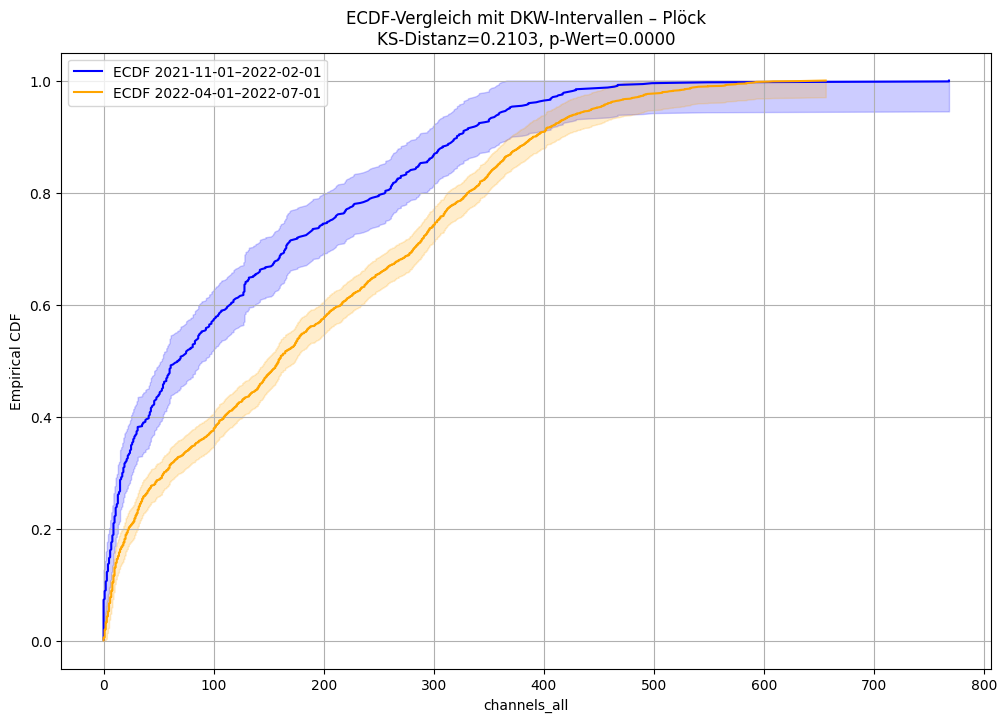

(np.float64(0.21029377516052833), np.float64(1.352427067572527e-19))

In [275]:
from scipy.stats import ks_2samp

def compare_empirical_cdfs_with_dkw(station_name, channel="channels_all", alpha=0.05,  interval1=("2021-11-01", "2022-02-01"), interval2=("2022-04-01", "2022-07-01"), fig_size=(12, 8)):
  x1, y1, lower1, upper1, _ = calc_empirical_cdf_with_dkw(station_name, channel, alpha, interval1)
  x2, y2, lower2, upper2, _ = calc_empirical_cdf_with_dkw(station_name, channel, alpha, interval2)

  raw1 = get_channel_values(station_name, channel, interval1)
  raw2 = get_channel_values(station_name, channel, interval2)
  # KS test
  stat, p_value = ks_2samp(raw1, raw2)

  plt.figure(figsize=fig_size)
  plt.plot(x1, y1, label=f'ECDF {interval1[0]}–{interval1[1]}', color='blue')
  plt.fill_between(x1, lower1, upper1, color='blue', alpha=0.2)

  plt.plot(x2, y2, label=f'ECDF {interval2[0]}–{interval2[1]}', color='orange')
  plt.fill_between(x2, lower2, upper2, color='orange', alpha=0.2)

  plt.xlabel(channel)
  plt.ylabel("Empirical CDF")
  plt.title(f"ECDF-Vergleich mit DKW-Intervallen – {station_name}\n"
            f"KS-Distanz={stat:.4f}, p-Wert={p_value:.4f}")
  plt.legend()
  plt.grid(True)
  plt.show()

  return stat, p_value

compare_empirical_cdfs_with_dkw(station_name=station, interval1=interval_winter, interval2=interval_summer)

### Calculate PMF

Not only look at a specific year, but include all summer / winter intervals from multiple years. 

In [276]:
start_year = 2019
end_year = 2024
station = "Ziegelhäuser Landstraße"

In [277]:
def get_interval_values_multi_year(station_name, start_year, end_year):
    result = {}
    for year in range(start_year, end_year):
        interval_summer = (f"{year}-04-01", f"{year}-07-01")
        interval_winter = (f"{year}-11-01", f"{year + 1}-02-01")

        df_summer = dl.get_bicycle(station_name, interval_summer).df
        df_winter = dl.get_bicycle(station_name, interval_winter).df

        result[year] = (df_summer, df_winter)
    return result


def flatten_interval_values(interval_dict, season="summer"):
    all_values = []
    for year, (summer, winter) in interval_dict.items():
        if season == "summer":
            all_values.append(summer)
        else:
            all_values.append(winter)
    return np.concatenate([v.to_numpy() for v in all_values])

In [278]:
def calc_empirical_pmf(values, bin_width=10, max_value=800):
    values = np.asarray(values)

    bins = np.arange(0, max_value + bin_width, bin_width)
    pmf, edges = np.histogram(values, bins=bins, density=True)
    counts, _ = np.histogram(values, bins=bins, density=False)
    bins_mid = (edges[:-1] + edges[1:]) / 2

    return bins_mid, pmf, counts, edges

In [279]:
def plot_empirical_pmf(bins_mid, pmf, title, bin_width=10, y_max=None, fig_size=(10,6)):
    plt.figure(figsize=fig_size)
    plt.bar(bins_mid, pmf, width=0.8 * bin_width, alpha=0.6)
    plt.xlabel("Counts")
    plt.ylabel("PMF")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if y_max is not None:
        plt.ylim(0, y_max)
    plt.show()

In [280]:
def plot_pmf_compare(values1, values2, label1, label2, bin_width=10, max_value=800, x_min=None, y_max=None, figsize=(12,6), title="PMF comparison"):

    bins = np.arange(0, max_value + bin_width, bin_width)

    pmf1, edges = np.histogram(values1, bins=bins, density=True)
    pmf2, _     = np.histogram(values2, bins=bins, density=True)
    bins_mid = (edges[:-1] + edges[1:]) / 2

    plt.figure(figsize=figsize)
    plt.bar(bins_mid, pmf1, width=0.8*bin_width, alpha=0.5, label=label1)
    plt.bar(bins_mid, pmf2, width=0.8*bin_width, alpha=0.5, label=label2)
    plt.xlabel("Counts")
    plt.ylabel("PMF")
    plt.title(title)
    if y_max is not None:
        plt.ylim(0, y_max)
    if x_min is not None:
        plt.xlim(x_min)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

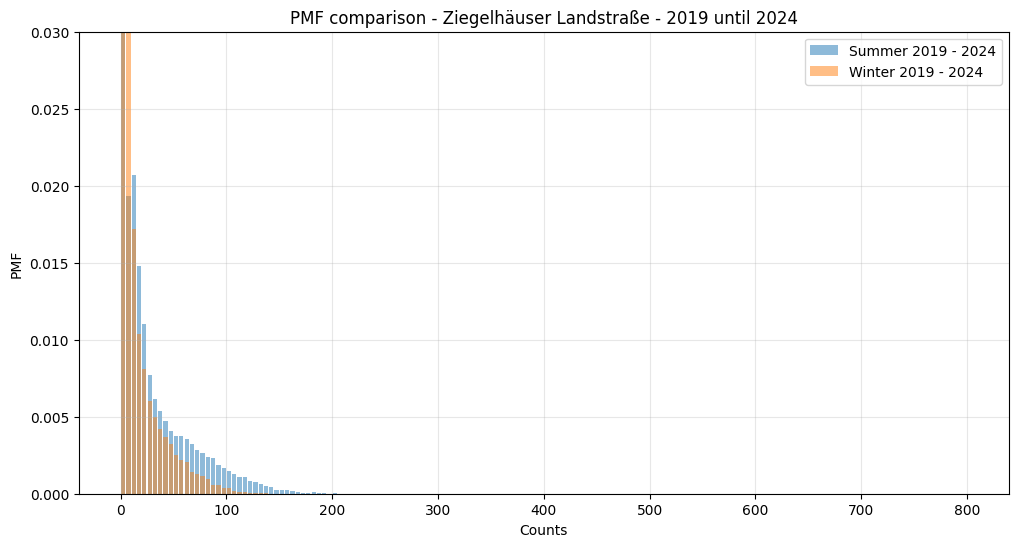

In [281]:
multi_year = get_interval_values_multi_year(station, start_year, end_year)

summer_values = flatten_interval_values(multi_year, season="summer")
winter_values = flatten_interval_values(multi_year, season="winter")

bins_mid_s, pmf_s, _, _ = calc_empirical_pmf(summer_values)
bins_mid_w, pmf_w, _, _ = calc_empirical_pmf(winter_values)

plot_pmf_compare(summer_values, winter_values, f"Summer {start_year} - {end_year}", f"Winter {start_year} - {end_year}", title=f"PMF comparison - {station} - {start_year} until {end_year}", bin_width=5, y_max=0.03)

In [ ]:
import polars as pl

def filter_bike_df(df, weekday=None, time_frame=(0, 24)):
    hour_min, hour_max = time_frame[0], time_frame[1]
    if weekday is not None:
        if weekday:
            df = df.filter(pl.col("datetime").dt.weekday() < 5)
        else:
            df = df.filter(pl.col("datetime").dt.weekday() >= 5)

    df = df.filter(
        (pl.col("datetime").dt.hour() >= hour_min) &
        (pl.col("datetime").dt.hour() < hour_max)
    )
    return df


def filtered_bike_df_multi_year(multi_year, season=None, weekday=None, time_frame = (0, 24)):
    dfs = []

    for year, (summer_df, winter_df) in multi_year.items():
        if season == "summer":
            df = summer_df
        elif season == "winter":
            df = winter_df
        else:
            df = pl.concat([summer_df, winter_df])
        df = filter_bike_df(df, weekday=weekday, time_frame=time_frame)
        dfs.append(df)

    return pl.concat(dfs)


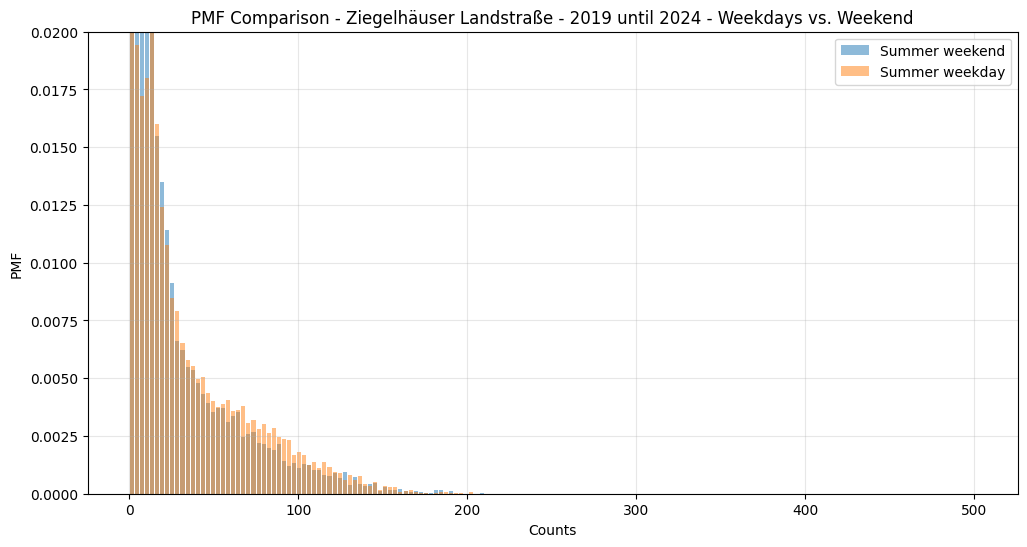

In [283]:
commute_summer_weekend = filtered_bike_df_multi_year(multi_year=multi_year, season="summer", weekday=False)
commute_summer_weekday = filtered_bike_df_multi_year(multi_year=multi_year, season="summer", weekday=True)

plot_pmf_compare(commute_summer_weekend, commute_summer_weekday, "Summer weekend", "Summer weekday", bin_width=3, y_max=0.02, max_value=500, title=f"PMF Comparison - {station} - {start_year} until {end_year} - Weekdays vs. Weekend")

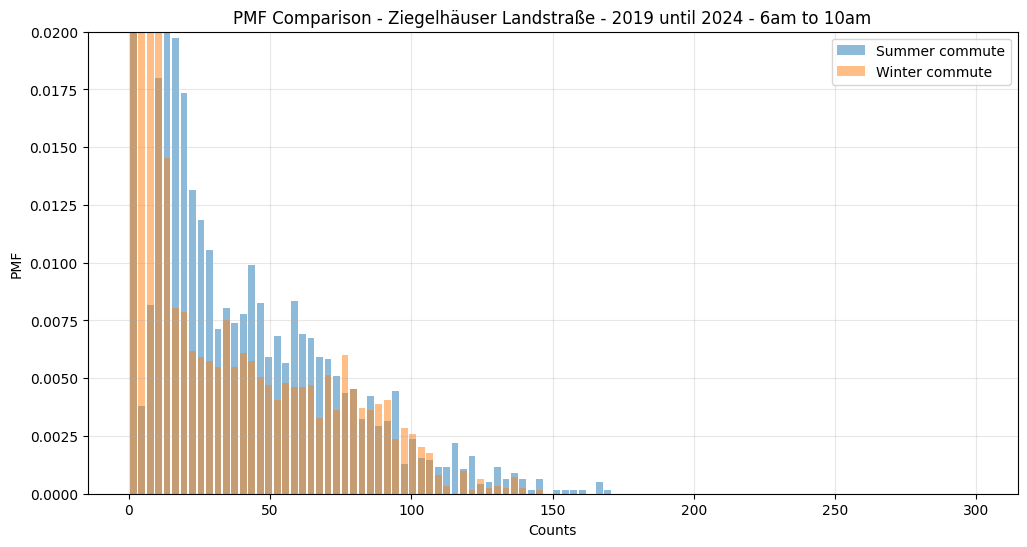

In [286]:
commute_summer = filtered_bike_df_multi_year(multi_year=multi_year, season="summer", weekday=True, time_frame=(6,10))
commute_winter = filtered_bike_df_multi_year(multi_year=multi_year, season="winter", weekday=True, time_frame=(6,10))

plot_pmf_compare(commute_summer, commute_winter, "Summer commute", "Winter commute", bin_width=3, x_min=None, y_max=0.02, max_value=300, title=f"PMF Comparison - {station} - {start_year} until {end_year} - 6am to 10am")